In [ ]:
!pip install lightning ipywidgets

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress tracking
import lightning as L
L.seed_everything(7, workers=True)
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint


class TrajectoryDataset(Dataset):
    def __init__(self, dataframe, window_length=100):
        # Perform the custom transformation
        sliced_df = self.custom_transformation(dataframe.to_numpy(), window_length=window_length)
        self.data = torch.tensor(sliced_df, dtype=torch.float32)

    def __len__(self):
        # Return the number of trajectories
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Get the trajectory at the given index
        return self.data[idx]

    def custom_transformation(self, dataframe_array, window_length):
        num_rows, num_cols = dataframe_array.shape
        window_length += 1  # get one more column as targets

        # Preallocate memory for the slices
        sliced_data = np.lib.stride_tricks.sliding_window_view(dataframe_array, window_shape=(window_length,), axis=1)

        # Reshape into a flat 2D array for DataFrame-like output
        sliced_data = sliced_data.reshape(-1, window_length)

        return sliced_data

Seed set to 7


In [2]:
class DataModule(L.LightningDataModule):
    def __init__(self, batch_size, window_length, train_df, val_df, test_df):
        super().__init__()
        self.batch_size = batch_size
        self.window_length = window_length
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
    
    def train_dataloader(self):
        ds = TrajectoryDataset(dataframe=self.train_df, window_length=self.window_length)
        ds = ds.data.reshape((-1, self.window_length+1, 1))
        return DataLoader(ds, batch_size=self.batch_size, shuffle=True, num_workers=3)
    
    def val_dataloader(self):
        ds = TrajectoryDataset(dataframe=self.val_df, window_length=self.window_length)
        ds = ds.data.reshape((-1, self.window_length+1, 1))
        return DataLoader(ds, batch_size=self.batch_size, shuffle=False, num_workers=3)
    
    def test_dataloader(self):
        ds = TrajectoryDataset(dataframe=self.test_df, window_length=self.window_length)
        ds = ds.data.reshape((-1, self.window_length+1, 1))
        return DataLoader(ds, batch_size=self.batch_size, shuffle=True, num_workers=3)

In [3]:
class LSTMModule(L.LightningModule):
    def __init__(self, loss_fn, learning_rate, 
                 input_size, 
                 hidden_size, 
                 num_stacked_layers, 
                 dropout_prob=0.2,
                ):
        super(LSTMModule, self).__init__()
        self.loss_fn = loss_fn
        self.learning_rate = learning_rate
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True, dropout=dropout_prob if num_stacked_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
        self.train_loss = []
        self.val_loss = []
    
    def forward(self, batch):
        batch_size = batch.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(batch.device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(batch.device)
        out, _ = self.lstm(batch, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def training_step(self, batch, batch_index):
        x_batch = batch[:, :-1]  # All except last column
        y_batch = batch[:, -1]

        output = self.forward(x_batch)
        loss = self.loss_fn(output, y_batch)
        self.train_loss.append(loss.item())
        return loss
    
    def on_train_epoch_end(self):
        self.log("train_loss_mean", torch.mean(torch.tensor(self.train_loss)).item(), sync_dist=True)
        self.print("train_loss_mean", torch.mean(torch.tensor(self.train_loss)).item())
        self.train_loss = []
    
    def validation_step(self, batch, batch_index):
        x_batch = batch[:, :-1]  # All except last column
        y_batch = batch[:, -1]
        output = self.forward(x_batch)
        loss = self.loss_fn(output, y_batch)
        self.val_loss.append(loss.item())
        return loss
    
    def on_validation_epoch_end(self):
        self.log("val_loss_mean", torch.mean(torch.tensor(self.val_loss)).item(), sync_dist=True)
        self.print("val_loss_mean", torch.mean(torch.tensor(self.val_loss)).item())
        self.val_loss = []
    
    def predict_step(self, batch):
        return self.forward(image)
    
    def lr_scheduler_step(self, scheduler, metric):
        if metric is None:
            scheduler.step()
        else:
            scheduler.step(metric)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)#, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,17,27], gamma=0.5, verbose=True)
        lr_scheduler = {
            'scheduler': scheduler,
            'monitor': 'val_loss_mean',
            'interval': 'epoch'
        }
        return ([optimizer], [lr_scheduler])
    

In [5]:
import os

# Get the relative path of a file in the current working directory
train_path = "train.csv"
val_path = "val.csv"
test_path = "test.csv"

train_df = pd.read_csv(train_path, header = 0).drop('ids', axis=1)
val_df = pd.read_csv(val_path, header = 0).drop('ids', axis=1)
test_df = pd.read_csv(test_path, header = 0).drop('ids', axis=1)

In [ ]:
lr_logger = LearningRateMonitor()
early_stopping = EarlyStopping('val_loss_mean', mode='min', patience=10)
model_checkpoint = ModelCheckpoint(dirpath="./MODELS",save_last=True, save_top_k=3, monitor="val_loss_mean")

In [10]:
window_length = 15
batch_size = 512
dm = DataModule(batch_size, window_length, train_df, val_df, test_df, )


In [ ]:
input_size = 1  # Window length minus 1 (since the last column is the target)
hidden_size = 60
number_of_stacked_layers = 1  # Single output for time series forecast (next value)
learning_rate = 0.0001
num_epochs = 60
criterion = nn.MSELoss()
lightning_model = LSTMModule(criterion, learning_rate, input_size, 
                             hidden_size, number_of_stacked_layers, dropout_prob=0.3)

In [ ]:
trainer = L.Trainer(max_epochs=num_epochs, callbacks=[lr_logger, early_stopping, model_checkpoint], strategy="ddp_notebook")

In [ ]:
trainer.fit(lightning_model, dm.train_dataloader(), dm.val_dataloader())

In [11]:
train_set = torch.tensor(train_df.values[:,:].astype(np.float32), dtype=torch.float32)
val_set = torch.tensor(val_df.values[:,:].astype(np.float32), dtype=torch.float32)
test_set = torch.tensor(val_df.values[:,:].astype(np.float32), dtype=torch.float32)

In [12]:
points_to_predict = val_set.shape[1]

In [13]:
from torch.nn import MSELoss
model = loaded_model
def autoregressive_predict(model, input_maxtrix, prediction_length=points_to_predict):
    """
    Perform autoregressive prediction using the learned model.
    
    Args:
    - model: The trained PyTorch model.
    - input_maxtrix: A matrix of initial time steps (e.g., shape (963, window_length)).
    - prediction_length: The length of the future trajectory to predict.
    
    Returns:
    - output_matrix: A tensor of the predicted future trajectory of the same length as `prediction_length`.
    """
    model.eval()  # Set model to evaluation mode
    output_matrix = torch.empty(input_maxtrix.shape[0],0,1)
    current_input = input_maxtrix
    
    with torch.no_grad():  # No need to calculate gradients for prediction
        for idx in range(prediction_length):
            # Predict the next time step
            next_pred = model(current_input)
            next_pred = next_pred.unsqueeze(2)
            # Concatenating the new column along dimension 1 (columns)
            output_matrix = torch.cat((output_matrix, next_pred), dim=1)
            
            # Use the predicted value as part of the next input
            current_input = torch.cat((current_input[:, 1:, :],next_pred),dim=1)
    
    return output_matrix


initial_input = train_set[:, -window_length:]  #use the last window of training set as initial input
initial_input = initial_input.reshape((-1, window_length, 1))
initial_input = initial_input
full_trajectories = autoregressive_predict(model, initial_input)


# Calculate MSE between predicted trajectories and actual validation trajectories using torch
mse_loss = MSELoss()

# Compute MSE
val_set = val_set.reshape((-1, val_set.shape[1], 1))
mse = mse_loss(full_trajectories, val_set)

# Print MSE
print(f'Autoregressive Validation MSE (using torch): {mse.item():.4f}')

Autoregressive Validation MSE (using torch): 0.0044


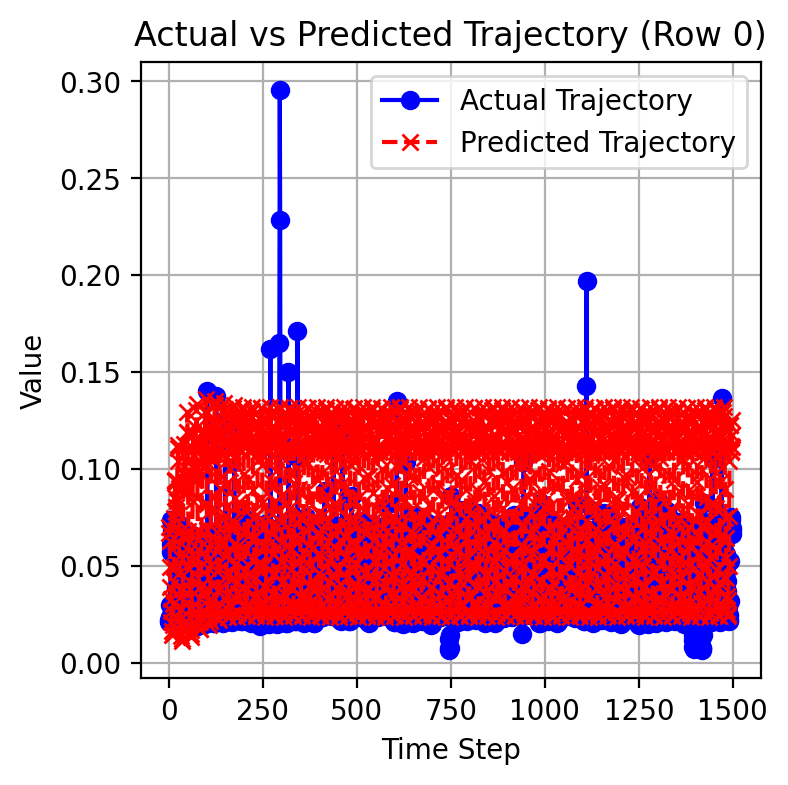

In [22]:
row_idx = 0  # You can change this to visualize predictions for different rows
initial_input = val_set[row_idx, :window_length].unsqueeze(0)

# Predict future trajectory of length 100
predicted_trajectory = autoregressive_predict(loaded_model, initial_input)

# Get the actual trajectory for comparison
actual_trajectory = val_set[row_idx].cpu().numpy()

# Plot the actual vs predicted trajectory
plt.figure(figsize=(4, 4), dpi=200)
plt.plot(range(len(actual_trajectory)), actual_trajectory, label="Actual Trajectory", color='blue', marker='o')
plt.plot(range(len(actual_trajectory)), predicted_trajectory.squeeze().cpu().numpy(), label="Predicted Trajectory", color='red', linestyle='--', marker='x')
plt.title(f"Actual vs Predicted Trajectory (Row {row_idx})")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.savefig(f"row_{row_idx}.png")
plt.show()

In [ ]:
# Generate predictions for all the validation dataset
initial_input = train_set[:, -window_length:]
initial_input = initial_input.reshape((-1, window_length, 1))
initial_input = initial_input
val_predictions_tensor = autoregressive_predict(model, initial_input)

# Generate predictions for all the test dataset
initial_input = val_predictions_tensor[:, -window_length:]
initial_input = initial_input.reshape((-1, window_length, 1))
initial_input = initial_input
test_predictions_tensor = autoregressive_predict(model, initial_input)


# Print their shapes
print(f'Validation Predictions Tensor Shape: {val_predictions_tensor.shape}')
print(f'Test Predictions Tensor Shape: {test_predictions_tensor.shape}')

In [ ]:
def generate_submissions_v4(pred_val_tensor, pred_test_tensor, original_val_path, original_test_path):
    # Read the original validation and testing datasets
    original_val_df = pd.read_csv(original_val_path)
    original_test_df = pd.read_csv(original_test_path)

    # Ensure the shape of pred_val_tensor and pred_test_tensor is correct
    assert pred_val_tensor.shape[0] * pred_val_tensor.shape[1] == original_val_df.shape[0] * (original_val_df.shape[1] - 1)
    assert pred_test_tensor.shape[0] * pred_test_tensor.shape[1] == original_test_df.shape[0] * (original_test_df.shape[1] - 1)

    # Create empty lists to store ids and values
    ids = []
    values = []

    # Process validation set
    for col_idx, col in enumerate(original_val_df.columns[1:]):  # Skip the 'ids' column
        for row_idx, _ in enumerate(original_val_df[col]):
            ids.append(str(f"{col}_traffic_val_{row_idx}"))
            values.append(float(pred_val_tensor[row_idx, col_idx]))

    # Process testing set
    for col_idx, col in enumerate(original_test_df.columns[1:]):  # Skip the 'ids' column
        for row_idx, _ in enumerate(original_test_df[col]):
            ids.append(str(f"{col}_traffic_test_{row_idx}"))
            values.append(float(pred_test_tensor[row_idx, col_idx]))

    # Create the submissions dataframe
    submissions_df = pd.DataFrame({
        "ids": ids,
        "value": values
    })
    
    # Impute any null values
    submissions_df.fillna(100, inplace=True)

    # Assert the shape of the dataframe
    assert submissions_df.shape[1] == 2
    assert submissions_df.shape[0] == (original_val_df.shape[0] * (original_val_df.shape[1] - 1)) + (original_test_df.shape[0] * (original_test_df.shape[1] - 1))
    assert "ids" in submissions_df.columns
    assert "value" in submissions_df.columns

    # Save to CSV
    submissions_df.to_csv('submissions_w_15_e_60_lr_0001_h_60_s_1_batch_512_no_decay_admw.csv', index=False)

# Call the function
generate_submissions_v4(val_predictions_tensor, test_predictions_tensor, val_path, test_path)